## Installations

In [6]:
!pip uninstall -y langchain langchain-community
!pip install -U "langchain-core>=1.1" "langchain-openai>=1.1" "langgraph>=0.5.0" --quiet

Found existing installation: langchain 0.3.10
Uninstalling langchain-0.3.10:
  Successfully uninstalled langchain-0.3.10
Found existing installation: langchain-community 0.3.31
Uninstalling langchain-community-0.3.31:
  Successfully uninstalled langchain-community-0.3.31
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-text-splitters 0.3.2 requires langchain-core<0.4.0,>=0.3.15, but you have langchain-core 1.1.0 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [7]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

print("LangGraph and OpenAI bindings imported successfully.")

LangGraph and OpenAI bindings imported successfully.


In [10]:
from database_setup import DatabaseSetup

db = DatabaseSetup("support.db")

db.connect()

db.create_tables()

db.create_triggers()

db.insert_sample_data()

db.close()

print("Database ready with tables and sample data.")


Connected to database: support.db
Tables created successfully!
Triggers created successfully!
Sample data inserted successfully!
  - 15 customers added
  - 25 tickets added
Database connection closed.
Database ready with tables and sample data.


# Sequential Multi-Agent Workflow — Customer Support Ticket Resolution

Author : Dr. Fouad Bousetouane - UChicago

Adapted by Devyani Mahajan

Goal:
Show how multiple AI agents can collaborate in a fixed sequence to automatically process and resolve customer support tickets — each agent performing a specific step and using a dedicated tool.

# Real-World Use Case: Automated Support Flow

A user submits a complaint:

“My order was charged twice but I only received one item.”

The system processes it sequentially through three agents:

Step	Agent Role	Tool Access	Example Action
1️	Intent Analyzer
(tool) Agent	Sentiment / NLU Tool
(output )Detects that this is a billing issue

2️	Knowledge Retriever Agent
(tool) FAQ / Knowledge-Base API
(output )Looks up the refund policy and duplicate charge procedure

3️	Response Generator Agent
(Tool) Template Formatter Tool
(output)Crafts a polite final reply to the customer with refund steps


# User Input → Intent Analyzer → Knowledge Retriever → Response Generator → Output


# Sequential Multi-Agent Pattern (Customer Support Example)

In [11]:
# =====================================================
# Sequential Multi-Agent System: Customer Support Ticket Resolution
# =====================================================

import os
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict

# =====================================================
# 1️  Setup API Key
# =====================================================
os.environ["OPENAI_API_KEY"] = ""


# =====================================================
# 2 Define Shared State
# =====================================================
class SupportState(TypedDict, total=False):
    input: str                        # raw user query
    customer_id: Optional[int]        # parsed or provided customer ID (used later)
    route: Optional[str]              # which agent to go to next (used later)
    response: Optional[str]           # final user-facing response
    customer_data: Optional[dict]     # data from Customer Data Agent (used later)
    tickets: Optional[list]           # ticket history or ticket list (used later)
    intent: Optional[str]             # intent label for this baseline pipeline
    knowledge: Optional[str]          # knowledge string for this baseline pipeline
    agent_log: str                    # cumulative log (used later)


# =====================================================
# 3 Define Tools 
# =====================================================

# ----- Tools for Intent Analyzer -----
def detect_intent(message: str) -> str:
    """Fake NLU model to classify intent."""
    message_lower = message.lower()
    if "charge" in message_lower or "refund" in message_lower:
        return "billing"
    elif "delay" in message_lower or "delivery" in message_lower:
        return "shipping"
    elif "broken" in message_lower or "not working" in message_lower:
        return "product"
    else:
        return "other"

def detect_sentiment(message: str) -> str:
    """Placeholder sentiment analysis tool."""
    if any(word in message.lower() for word in ["angry", "upset", "disappointed"]):
        return "negative"
    else:
        return "neutral"

# ----- Tools for Knowledge Retriever -----
def lookup_kb(intent: str) -> str:
    """Mock lookup from knowledge base."""
    kb = {
        "billing": "Duplicate charges can be refunded within 5 business days.",
        "shipping": "Shipping delays can be tracked via the courier website.",
        "product": "Product defects are covered under a 30-day replacement policy.",
        "other": "General inquiries are handled by our care team."
    }
    return kb.get(intent, "No policy found.")

def search_faq(intent: str) -> str:
    """Mock FAQ search tool."""
    return f"FAQ result: Steps for resolving {intent} issues."

# ----- Tools for Response Generator -----
def generate_response(user_input: str, knowledge: str) -> str:
    """Compose a natural response using retrieved info."""
    return (
        "Thank you for contacting us. "
        f"Based on your message: '{user_input}', here’s what we found:\n\n"
        f"{knowledge}\n\nWe hope this helps!"
    )

def format_message(response: str) -> str:
    """Placeholder for formatting output."""
    return f"Customer Support:\n{response}"


# =====================================================
# 4 Define the Agents 
# =====================================================
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# --- Agent 1: Intent Analyzer ---
def intent_analyzer(state: SupportState) -> SupportState:
    """LLM decides which tool to use."""
    user_input = state["input"]
    reasoning_prompt = f"""
    You are an intent analysis agent.
    Tools available: detect_intent(), detect_sentiment().
    Decide which tool to use based on this message:
    \"{user_input}\"
    Explain your reasoning briefly and return only the chosen tool name.
    """
    tool_choice = llm.invoke(reasoning_prompt).content.strip().lower()

    if "sentiment" in tool_choice:
        tool_result = detect_sentiment(user_input)
    else:
        tool_result = detect_intent(user_input)

    # For this baseline pipeline, we store the result in 'intent'
    return {**state, "intent": tool_result}

# --- Agent 2: Knowledge Retriever ---
def knowledge_retriever(state: SupportState) -> SupportState:
    """Agent decides which lookup tool to use based on intent."""
    intent = state["intent"]
    reasoning_prompt = f"""
    You are a knowledge retriever.
    Tools available: lookup_kb(), search_faq().
    The detected intent is: {intent}.
    Decide which tool to use and return only the tool name.
    """
    tool_choice = llm.invoke(reasoning_prompt).content.strip().lower()

    if "faq" in tool_choice:
        tool_result = search_faq(intent)
    else:
        tool_result = lookup_kb(intent)

    return {**state, "knowledge": tool_result}

# --- Agent 3: Response Generator ---
def response_generator(state: SupportState) -> SupportState:
    """Agent chooses how to generate and format the reply."""
    user_input = state["input"]
    knowledge = state["knowledge"]

    reasoning_prompt = """
    You are a response generator.
    Tools available: generate_response(), format_message().
    You should use both tools — first to generate a response, then to format it.
    Just confirm that plan in your own mind; no need to output anything special.
    """
    _ = llm.invoke(reasoning_prompt).content.strip()  # purely reasoning, ignored

    raw_reply = generate_response(user_input, knowledge)
    final_reply = format_message(raw_reply)

    return {**state, "response": final_reply}


# =====================================================
# 5 Build Sequential Graph 
# =====================================================
sequential_graph = StateGraph(SupportState)

sequential_graph.add_node("IntentAnalyzer", intent_analyzer)
sequential_graph.add_node("KnowledgeRetriever", knowledge_retriever)
sequential_graph.add_node("ResponseGenerator", response_generator)

sequential_graph.add_edge(START, "IntentAnalyzer")
sequential_graph.add_edge("IntentAnalyzer", "KnowledgeRetriever")
sequential_graph.add_edge("KnowledgeRetriever", "ResponseGenerator")
sequential_graph.add_edge("ResponseGenerator", END)

sequential_support_pipeline = sequential_graph.compile()


# =====================================================
# 6 Test the Full Sequential System
# =====================================================
print("Running Sequential Multi-Agent System with Tool Reasoning...\n")

result = sequential_support_pipeline.invoke({
    "input": "My order was charged twice and I’m still waiting for a refund."
})

# =====================================================
# 7 Show Final Output
# =====================================================
print("Final Response:\n")
print(result["response"])

print("\nIntermediate State:")
print(f"Intent: {result['intent']}")
print(f"Knowledge: {result['knowledge']}")

 Running Sequential Multi-Agent System with Tool Reasoning...



AuthenticationError: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to provide your API key in an Authorization header using Bearer auth (i.e. Authorization: Bearer YOUR_KEY), or as the password field (with blank username) if you're accessing the API from your browser and are prompted for a username and password. You can obtain an API key from https://platform.openai.com/account/api-keys.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

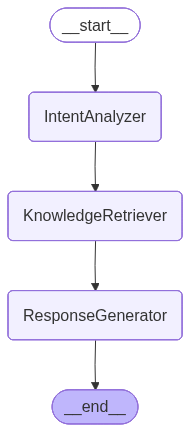

In [ ]:
support_pipeline

# Title: Orchestrator-Based Multi-Agent System — Customer Support Assistant

Goal:
Demonstrate how a Router (Orchestrator Agent) can dynamically select which specialized agent to activate based on the user’s query.

Use Case Example:
A user sends a support message like:

“My product arrived damaged.”
“I want a refund.”
“The delivery is late.”

The Router Agent analyzes intent and dispatches the message to the appropriate specialized agent:

 BillingAgent → refund & payment issues

 ShippingAgent → delivery or delay issues

ProductAgent → defective or missing product issues

Each sub-agent has access to its own tools (simulated placeholders).

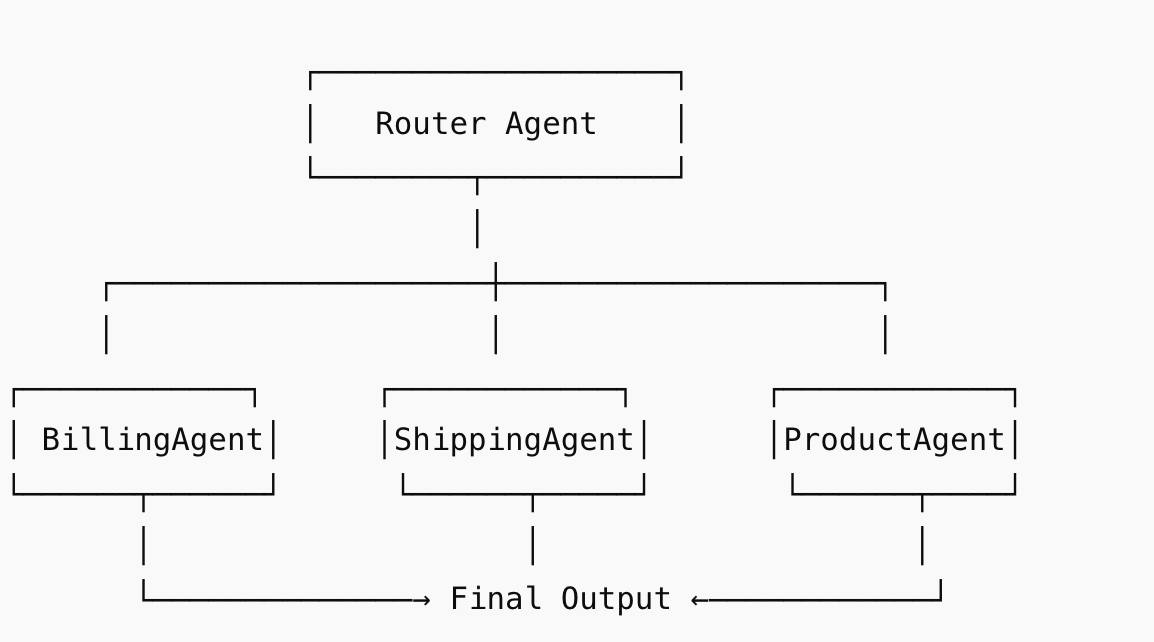

# Orchestrator (Router) Pattern

In [ ]:
# =====================================================
# Orchestrator (Router-Based) Multi-Agent System: Customer Support
# =====================================================



import os
import sqlite3
import json
import re
from typing import TypedDict, Optional, Dict, Any, List

from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI


DB_PATH = "support.db"

# =====================================================
# 1️ Database-backed tools (same interface as MCP tools)
# =====================================================

def get_connection():
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    return conn

def get_customer(customer_id: int) -> Dict[str, Any]:
    conn = get_connection()
    try:
        cur = conn.cursor()
        cur.execute("SELECT * FROM customers WHERE id = ?", (customer_id,))
        row = cur.fetchone()
        return dict(row) if row else {}
    finally:
        conn.close()

def list_customers(status: str = "active", limit: int = 10) -> List[Dict[str, Any]]:
    conn = get_connection()
    try:
        cur = conn.cursor()
        cur.execute(
            "SELECT * FROM customers WHERE status = ? LIMIT ?", 
            (status, limit)
        )
        rows = cur.fetchall()
        return [dict(r) for r in rows]
    finally:
        conn.close()

def update_customer(customer_id: int, data: Dict[str, Any]) -> Dict[str, Any]:
    conn = get_connection()
    try:
        cur = conn.cursor()

        fields = []
        values = []
        for k, v in data.items():
            fields.append(f"{k} = ?")
            values.append(v)
        values.append(customer_id)

        sql = f"UPDATE customers SET {', '.join(fields)} WHERE id = ?"
        cur.execute(sql, values)
        conn.commit()

        cur.execute("SELECT * FROM customers WHERE id = ?", (customer_id,))
        row = cur.fetchone()
        return dict(row) if row else {}
    finally:
        conn.close()

def create_ticket(customer_id: int, issue: str, priority: str = "medium") -> Dict[str, Any]:
    conn = get_connection()
    try:
        cur = conn.cursor()
        cur.execute(
            """
            INSERT INTO tickets (customer_id, issue, status, priority, created_at)
            VALUES (?, ?, 'open', ?, CURRENT_TIMESTAMP)
            """,
            (customer_id, issue, priority),
        )
        conn.commit()
        ticket_id = cur.lastrowid
        cur.execute("SELECT * FROM tickets WHERE id = ?", (ticket_id,))
        row = cur.fetchone()
        return dict(row)
    finally:
        conn.close()

def get_customer_history(customer_id: int) -> Dict[str, Any]:
    """Return both customer and their tickets."""
    conn = get_connection()
    try:
        cur = conn.cursor()
        cur.execute("SELECT * FROM customers WHERE id = ?", (customer_id,))
        cust = cur.fetchone()
        if not cust:
            return {"customer": None, "tickets": []}
        cur.execute(
            "SELECT * FROM tickets WHERE customer_id = ? ORDER BY created_at DESC",
            (customer_id,),
        )
        tickets = [dict(r) for r in cur.fetchall()]
        return {"customer": dict(cust), "tickets": tickets}
    finally:
        conn.close()


# =====================================================
# 2️ Define Agents (Router, CustomerData, Support)
# =====================================================

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# --- Router Agent (Orchestrator) ---
def router_agent(state: SupportState) -> SupportState:
    """
    Classify the user's query into an intent and extract customer_id if present.
    This is the orchestration brain that decides how to route the task.
    """
    query = state["input"]
    log = state.get("agent_log", "")

    # Try to find an explicit numeric ID in the text (e.g. 'customer ID 5')
    match = re.search(r"\b(?:id|ID)\s*(\d+)\b", query)
    customer_id = int(match.group(1)) if match else state.get("customer_id")

    intent_prompt = f"""
    You are a router agent for a customer support system.

    User message: "{query}"

    Choose an intent from:
      - "simple_lookup": get info for a single customer id
      - "upgrade": upgrade an account
      - "billing_issue": billing / charged twice / refund
      - "active_with_open_tickets": report on active customers with open tickets
      - "update_and_history": update contact info and show ticket history
      - "general_support": anything else

    Also set urgency to "high" if the user sounds urgent (charged twice, refund immediately),
    otherwise "low".

    Respond ONLY with valid JSON like:
    {{
      "intent": "...",
      "urgency": "high" or "low"
    }}
    """

    raw = llm.invoke(intent_prompt).content
    try:
        parsed = json.loads(raw)
        intent = parsed.get("intent", "general_support")
        urgency = parsed.get("urgency", "low")
    except Exception:
        intent = "general_support"
        urgency = "low"

    # Decide route pattern: all intents go via CustomerDataAgent first,
    # except very generic ones where we might not have a customer id.
    if intent in {"simple_lookup", "upgrade", "billing_issue", "update_and_history", "active_with_open_tickets"}:
        route = "data_then_support"
    else:
        route = "support_only"

    log += f"[Router] intent={intent}, urgency={urgency}, customer_id={customer_id}, route={route}\n"

    return {
        **state,
        "intent": intent,
        "urgency": urgency,
        "customer_id": customer_id,
        "route": route,
        "agent_log": log,
    }


# --- Customer Data Agent ---
def customer_data_agent(state: SupportState) -> SupportState:
    """
    Responsible for talking to the customer/ticket database.
    Uses our MCP-style tools (here as direct functions).
    """
    log = state.get("agent_log", "")
    query = state["input"].lower()
    intent = state.get("intent", "general_support")
    cid = state.get("customer_id")

    customer = None
    tickets = []
    customers = None

    # Per-customer context if we have an ID
    if cid is not None:
        history = get_customer_history(cid)
        customer = history["customer"]
        tickets = history["tickets"]
        log += f"[CustomerDataAgent] get_customer_history({cid}) → {len(tickets)} tickets\n"

    # Multi-customer context for report-style queries
    if intent == "active_with_open_tickets" or "all active customers" in query:
        customers = list_customers(status="active", limit=100)
        log += f"[CustomerDataAgent] list_customers('active') → {len(customers)} customers\n"

    return {
        **state,
        "customer_data": customer,
        "tickets": tickets,
        "customers": customers,
        "agent_log": log,
    }


# --- Support Agent ---
def support_agent(state: SupportState) -> SupportState:
    """
    Uses the routed intent and the customer/ticket context to produce
    a final response (and optionally create tickets or update records).
    """
    query = state["input"]
    intent = state.get("intent", "general_support")
    urgency = state.get("urgency", "low")
    customer = state.get("customer_data")
    tickets = state.get("tickets", []) or []
    customers = state.get("customers")
    cid = state.get("customer_id")
    log = state.get("agent_log", "")

    # Scenario 1: Simple lookup
    if intent == "simple_lookup":
        if not customer:
            resp = "I could not find that customer. Please double check the ID."
        else:
            resp = (
                f"Customer {customer['id']}: {customer['name']}\n"
                f"Email: {customer.get('email')}\n"
                f"Phone: {customer.get('phone')}\n"
                f"Status: {customer.get('status')}"
            )
        log += "[SupportAgent] Handled simple_lookup.\n"
        return {**state, "response": resp, "agent_log": log}

    # Scenario 2: Upgrade flow
    if intent == "upgrade":
        if not customer:
            resp = "I could not find your account. Please provide a valid customer ID."
        else:
            resp = (
                f"Hi {customer['name']}, I can help you upgrade your account. "
                f"I will use the email on file ({customer.get('email')}) to send confirmation."
            )
        log += "[SupportAgent] Handled upgrade flow.\n"
        return {**state, "response": resp, "agent_log": log}

    # Scenario 3: Billing / escalation
    if intent == "billing_issue":
        priority = "high" if urgency == "high" else "medium"
        created = None
        if cid is not None:
            created = create_ticket(cid, query, priority=priority)
            log += f"[SupportAgent] create_ticket({cid}, priority={priority}) → ticket_id={created['id']}\n"
        resp = (
            "I am sorry for the billing issue. I have created a ticket"
            f"{f' #{created['id']}' if created else ''} with priority {priority}. "
            "Our billing team will review your charge and process any refund that is due."
        )
        return {**state, "response": resp, "agent_log": log}

    # Scenario 4: Active customers with open tickets (multi-customer report)
    if intent == "active_with_open_tickets" and customers is not None:
        lines = []
        for c in customers:
            history = get_customer_history(c["id"])
            open_tickets = [t for t in history["tickets"] if t["status"] == "open"]
            if open_tickets:
                lines.append(f"- {c['id']} {c['name']}: {len(open_tickets)} open ticket(s)")
        if not lines:
            resp = "There are no active customers with open tickets right now."
        else:
            resp = "Active customers with open tickets:\n" + "\n".join(lines)
        log += "[SupportAgent] Generated report for active customers with open tickets.\n"
        return {**state, "response": resp, "agent_log": log}

    # Scenario 5: Update email and show history (multi-intent)
    if intent == "update_and_history" and cid is not None:
        # simple email regex to find new email in the query
        match = re.search(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", query.lower())
        if match:
            new_email = match.group(0)
            updated = update_customer(cid, {"email": new_email})
            history = get_customer_history(cid)
            lines = [f"- [{t['status']}] {t['issue']}" for t in history["tickets"]]
            resp = (
                f"Updated email to {updated.get('email')} for customer {updated['name']}.\n\n"
                f"Ticket history ({len(history['tickets'])} total):\n"
                + "\n".join(lines)
            )
            log += "[SupportAgent] Updated email and summarized ticket history.\n"
        else:
            resp = "I could not find a valid email address to update."
        return {**state, "response": resp, "agent_log": log}

    # Fallback: general support
    resp = "I have logged your issue and will route it to the appropriate team."
    log += "[SupportAgent] Fallback general_support.\n"
    return {**state, "response": resp, "agent_log": log}


# =====================================================
# 3️ Build LangGraph with Router Logic
# =====================================================

graph = StateGraph(SupportState)

graph.add_node("Router", router_agent)
graph.add_node("CustomerDataAgent", customer_data_agent)
graph.add_node("SupportAgent", support_agent)

graph.add_edge(START, "Router")

def router_next(state: SupportState) -> str:
    """
    Decide the next node after the Router.
    For now, anything with route 'data_then_support' goes to CustomerDataAgent,
    otherwise directly to SupportAgent.
    """
    route = state.get("route", "data_then_support")
    if route == "data_then_support":
        return "CustomerDataAgent"
    return "SupportAgent"

graph.add_conditional_edges(
    "Router",
    router_next,
    {
        "CustomerDataAgent": "CustomerDataAgent",
        "SupportAgent": "SupportAgent",
    },
)

graph.add_edge("CustomerDataAgent", "SupportAgent")
graph.add_edge("SupportAgent", END)

router_system = graph.compile()


# =====================================================
# 4️ Run Demo Queries (examples mirroring assignment scenarios)
# =====================================================

test_queries = [
    # Simple lookup
    "Get customer information for ID 5",
    # Task allocation / upgrade
    "I am customer ID 3 and need help upgrading my account",
    # Billing / escalation
    "I am customer ID 2 and have been charged twice, please refund immediately!",
    # Multi-customer report
    "Show me all active customers who have open tickets",
    # Update + history
    "I am customer ID 4, update my email to new_email@example.com and show my ticket history",
]

print("\nRunning Router-Based Multi-Agent System...\n")

for query in test_queries:
    print("=============================================")
    print(f"USER: {query}")
    print("=============================================")
    result = router_system.invoke({"input": query, "agent_log": ""})
    print("\nFinal Output:\n")
    print(result["response"])
    print("\nAgent Log:\n")
    print(result.get("agent_log", ""))
    print()



 Running Multi-Agent Router System...

 USER: I was charged twice for my order.

 [RouterAgent] Decision: BILLING selected.

 [BillingAgent] Used tool: refund_tool
 Response: [Billing Tool] → Refund initiated for: 'I was charged twice for my order.' within 5 days.


 Final Output: [Billing Tool] → Refund initiated for: 'I was charged twice for my order.' within 5 days.
Agent Path: BillingAgent → refund_tool

 USER: My package still hasn’t arrived.

 [RouterAgent] Decision: SHIPPING selected.

 [ShippingAgent] Used tool: shipping_tool
 Response: [Shipping Tool] → Tracking investigation opened for: 'My package still hasn’t arrived.'.


 Final Output: [Shipping Tool] → Tracking investigation opened for: 'My package still hasn’t arrived.'.
Agent Path: ShippingAgent → shipping_tool

 USER: The item I received is broken.

 [RouterAgent] Decision: PRODUCT selected.

 [ProductAgent] Used tool: product_tool
 Response: [Product Tool] → Replacement started for: 'The item I received is broken.'.


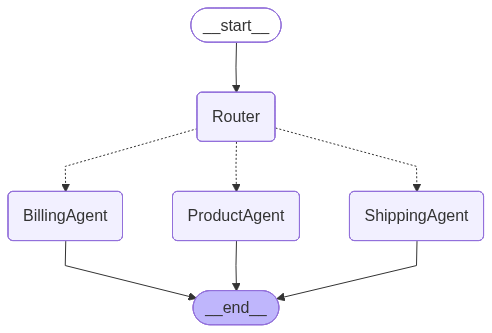

In [ ]:
router_system